In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import json
import re

In [2]:
def extract_training_times(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
    
    model_data = []
    current_model = None
    epoch_times = []

    for line in lines:
        model_match = re.match(r"evaluating model (.+)", line)
        epoch_match = re.match(r"Epoch \d+/5", line)
        time_match = re.search(r"- (\d+)s", line)
        
        if model_match:
            if current_model and epoch_times:
                model_data.append((current_model, epoch_times))
            current_model = model_match.group(1)
            epoch_times = []
        elif time_match:
            epoch_time = int(time_match.group(1))
            epoch_times.append(epoch_time)

    if current_model and epoch_times:
        model_data.append((current_model, epoch_times))

    return model_data

def calculate_total_training_times(model_data):
    data = {
        "Model": [],
        "Epoch 1": [],
        "Epoch 2": [],
        "Epoch 3": [],
        "Epoch 4": [],
        "Epoch 5": [],
        "Total Training Time (s)": []
    }
    
    for model, times in model_data:
        data["Model"].append(model)
        for i in range(5):
            if i < len(times):
                data[f"Epoch {i+1}"].append(times[i])
            else:
                data[f"Epoch {i+1}"].append(0)
        data["Total Training Time (s)"].append(sum(times))
    
    return pd.DataFrame(data)

def integrate_training_times(results_path, file_path):
    model_data = extract_training_times(file_path)
    df = calculate_total_training_times(model_data)
    training_times = df.to_dict(orient="records")

    with open(results_path, 'r') as f:
        results = json.load(f)

    for time_entry in training_times:
        model_name = time_entry["Model"]
        if model_name in results:
            results[model_name]["training_time_s"] = time_entry["Total Training Time (s)"]

    return results

# Pfade zu den Dateien
results_path = 'results/results.json'
file_path = "results/output.txt" 

# Integration und Speichern der Ergebnisse
integrated_results = integrate_training_times(results_path, file_path)

output_path = 'results/results_with_training_times.json'
with open(output_path, 'w') as f:
    json.dump(integrated_results, f, indent=4)

print(f'Ergebnisse mit Trainingszeiten wurden in {output_path} gespeichert.')


Ergebnisse mit Trainingszeiten wurden in results/results_with_training_times.json gespeichert.


In [3]:

# Laden der JSON-Datei
file_path = 'results/results_with_training_times.json'
with open(file_path) as f:
    data = json.load(f)

# Convert the data to a DataFrame for easier analysis
df = pd.DataFrame(data).T
df.reset_index(inplace=True)
df.rename(columns={'index': 'model'}, inplace=True)

# Daten in ein DataFrame umwandeln
df = pd.DataFrame(data).T
df['model'] = df.index
df = df.reset_index(drop=True)

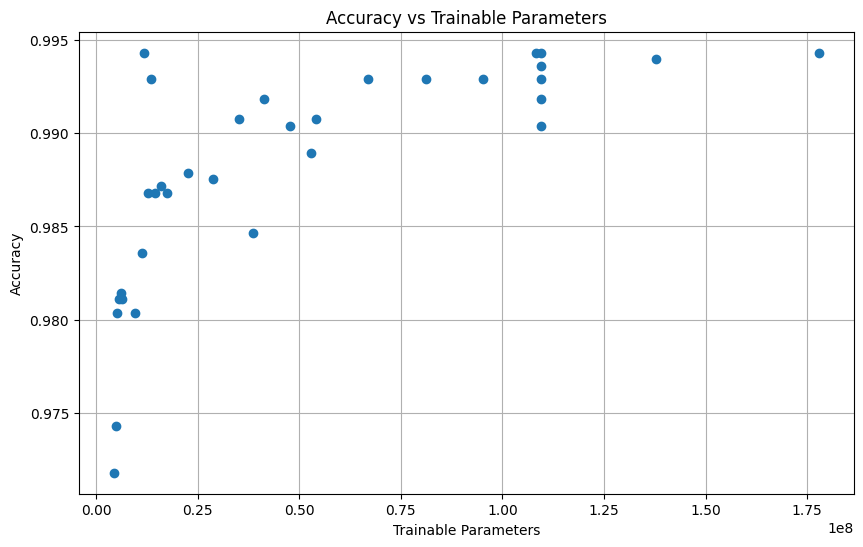

In [4]:
# Scatter plot for Accuracy vs Trainable Parameters
plt.figure(figsize=(10, 6))
plt.scatter(df['trainable_params'], df['accuracy'])
plt.title('Accuracy vs Trainable Parameters')
plt.xlabel('Trainable Parameters')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

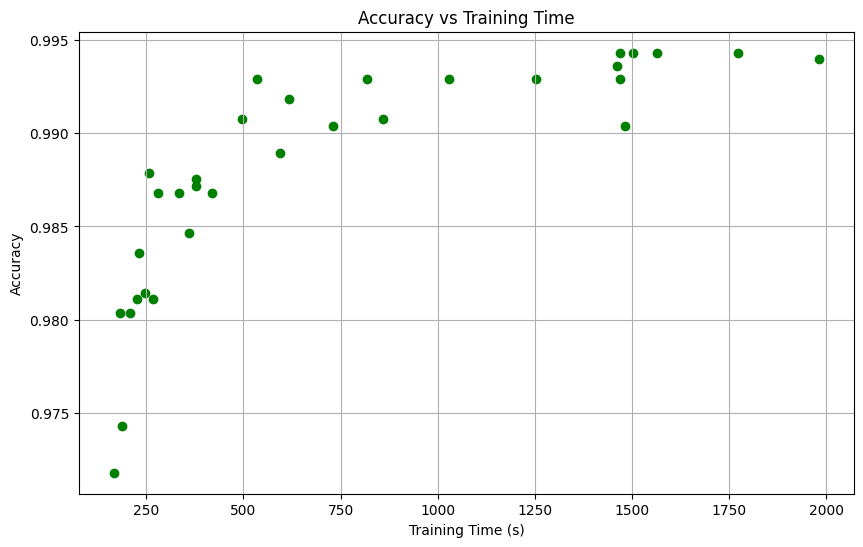

In [5]:
# Scatter plot for Accuracy vs Training Time
plt.figure(figsize=(10, 6))
plt.scatter(df['training_time_s'], df['accuracy'], color='g')
plt.title('Accuracy vs Training Time')
plt.xlabel('Training Time (s)')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

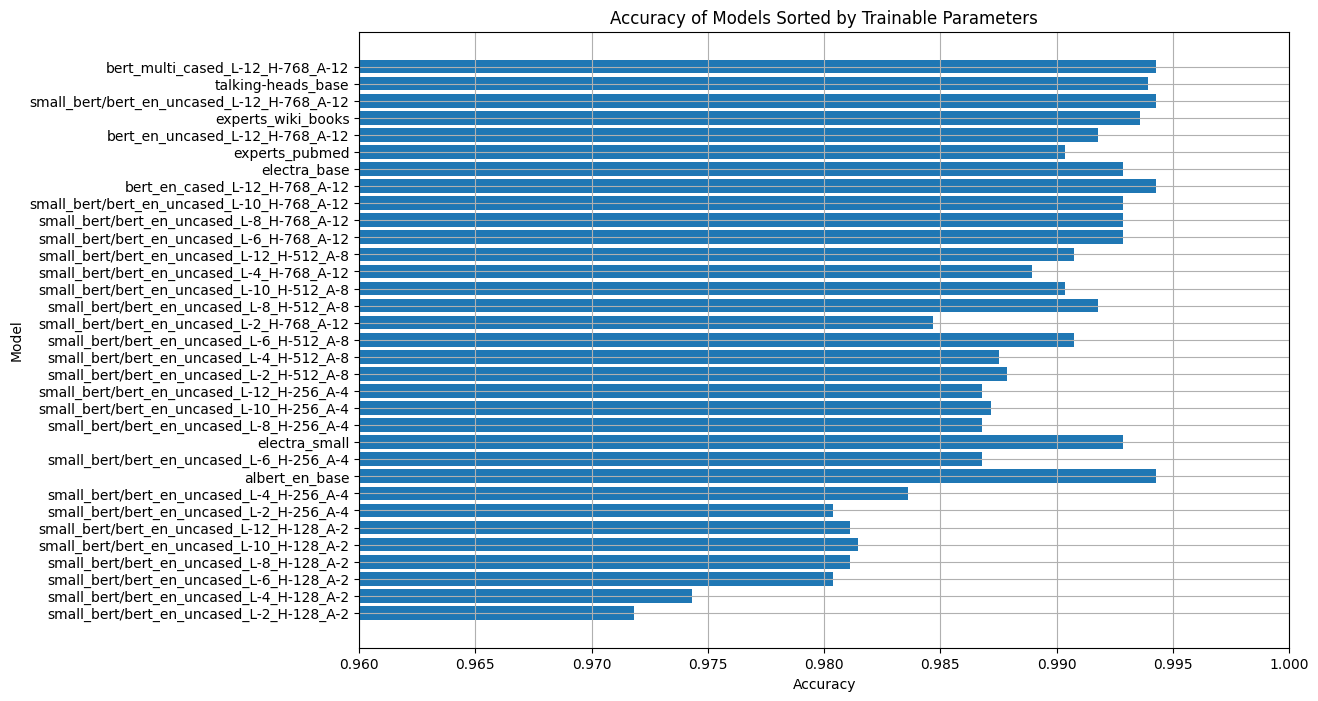

In [6]:
# Bar plot for Accuracy sorted by Trainable Parameters
df_sorted_params = df.sort_values(by='trainable_params')

plt.figure(figsize=(12, 8))
plt.barh(df_sorted_params['model'], df_sorted_params['accuracy'])
plt.title('Accuracy of Models Sorted by Trainable Parameters')
plt.xlabel('Accuracy')
plt.ylabel('Model')
plt.xlim(0.96, 1.0)
plt.grid(True)
plt.show()

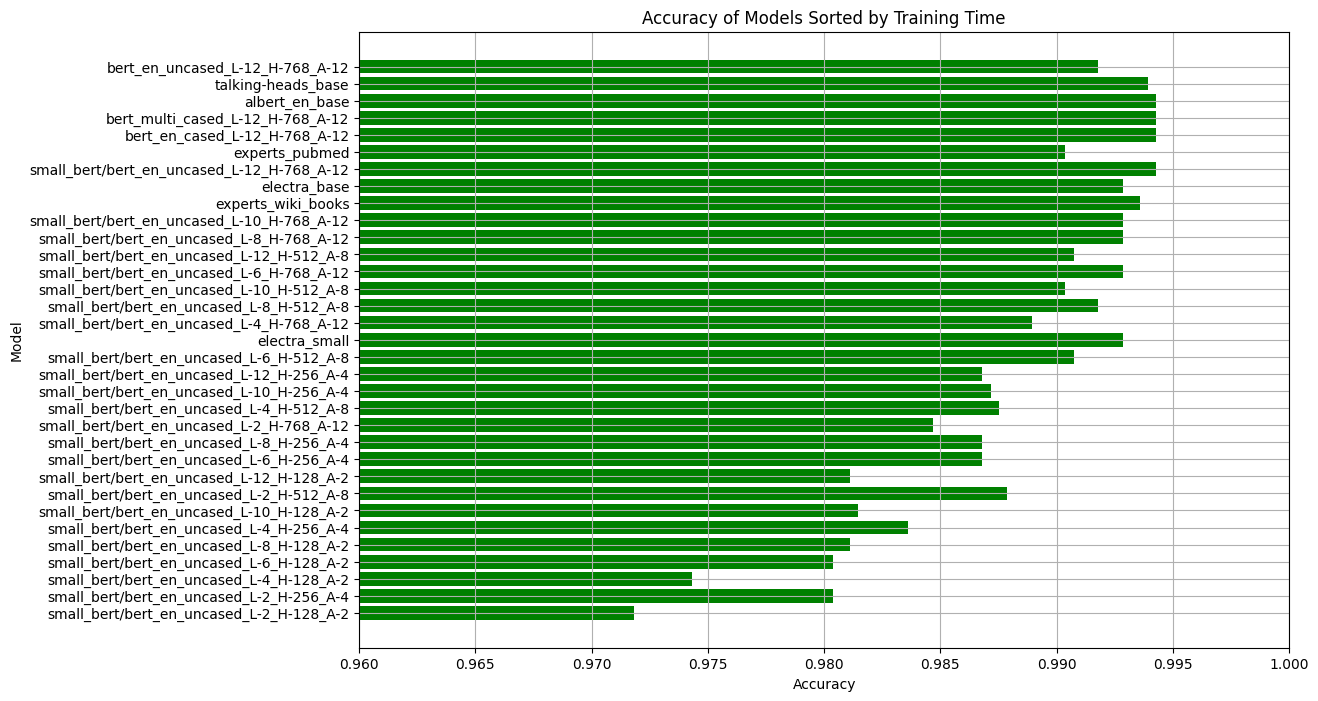

In [7]:
# Bar plot for Accuracy sorted by Training Time
df_sorted_time = df.sort_values(by='training_time_s')

plt.figure(figsize=(12, 8))
plt.barh(df_sorted_time['model'], df_sorted_time['accuracy'], color='g')
plt.title('Accuracy of Models Sorted by Training Time')
plt.xlabel('Accuracy')
plt.ylabel('Model')
plt.xlim(0.96, 1.0)
plt.grid(True)
plt.show()